<a href="https://colab.research.google.com/github/ashwinperti/LSTM_phd/blob/main/lstm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [41]:
base_csv = 'movie_data.csv'
df = pd.read_csv(base_csv, engine='python', error_bad_lines=False)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 36632: unexpected end of data


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


shape of train data is (27472,)
shape of test data is (9158,)


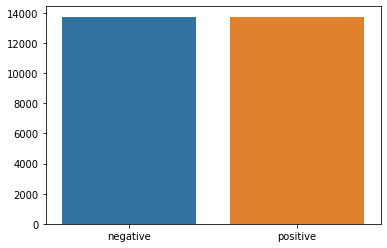

In [42]:
X, y = df['review'].values, df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Length of vocabulary is 1000


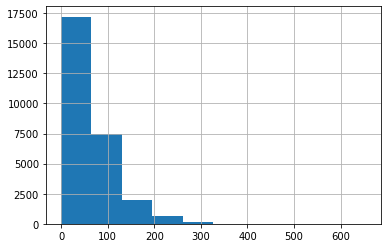

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 336,  67,   7],
        [  0,   0,   0,  ..., 798, 826, 288],
        [  0,   0,   0,  ..., 831,   3, 846],
        ...,
        [  0,   0,   0,  ..., 568, 432,   1],
        [  0,   0,   0,  ...,  60,   5, 525],
        [  0,   0,   0,  ...,  47, 606,   3]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [44]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')

rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

In [10]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

GPU is available
SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [13]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.34262346759438517 val_loss : 0.339274450302124
train_accuracy : 85.488 val_accuracy : 85.14399999999999
Validation loss decreased (inf --> 0.339274).  Saving model ...
Epoch 2
train_loss : 0.30891206276416777 val_loss : 0.3290041715502739
train_accuracy : 86.856 val_accuracy : 86.032
Validation loss decreased (0.339274 --> 0.329004).  Saving model ...
Epoch 3
train_loss : 0.2797532272736232 val_loss : 0.3245178155899048
train_accuracy : 88.53866666666667 val_accuracy : 86.088
Validation loss decreased (0.329004 --> 0.324518).  Saving model ...
Epoch 4
train_loss : 0.2383811497737964 val_loss : 0.3501507088840008
train_accuracy : 90.35466666666667 val_accuracy : 85.96000000000001
Epoch 5
train_loss : 0.18359137377639612 val_loss : 0.3981481117606163
train_accuracy : 92.896 val_accuracy : 84.464


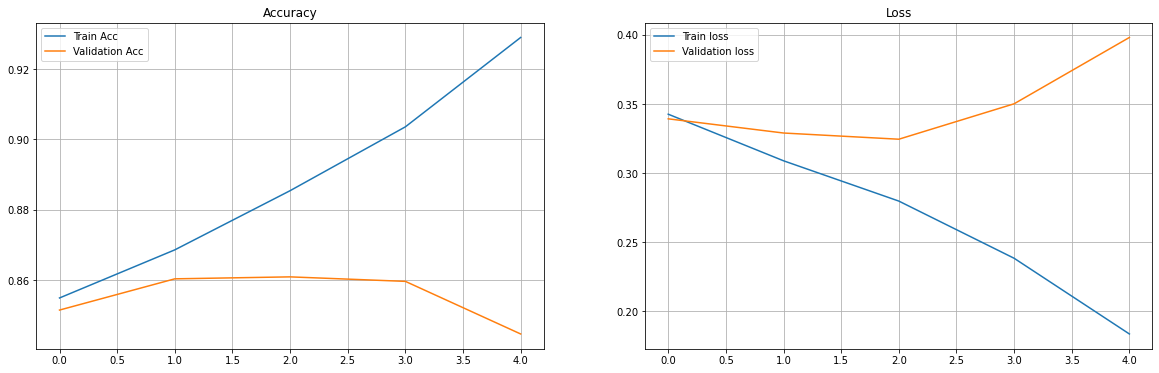

<Figure size 432x288 with 0 Axes>

In [16]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()
plt.savefig("model1.png")

In [17]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')



Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [18]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as "Spider Baby". The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket.
Actual sentiment is  : negative
predicted sentiment is negative with a probability of 0.9705355875194073


In [20]:
!pip install pyprind

In [45]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np
df = pd.read_csv('IMDB.csv', encoding='utf-8')

from collections import Counter
counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), \
            title='Counting words occurrences')

for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                            for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

## Create a mapping
## Map each unique word to an integer
word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])

Counting words occurrences
0% [##############################] 100% | ETA: 00:00:00

['the', '.', ',', 'and', 'a']



Total time elapsed: 00:00:22


In [23]:
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), \
                 title='Map reviews to ints')
for review in df['review']:
        mapped_reviews.append([word_to_int[word] \
                    for word in review.split()])
        pbar.update()

## Define same-length sequences
## if sequence length < 200: left-pad with zeros
## if sequence length > 200: use the last 200 elements

sequence_length = 200 ## (Known as T in our RNN formulas)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

for i, row in enumerate(mapped_reviews):
         review_arr = np.array(row)
         sequences[i, -len(row):] = review_arr[-sequence_length:]

X_train = sequences[:25000,:]
y_train = df.loc[:25000, 'sentiment'].values
X_test = sequences[25000:,:]
y_test = df.loc[25000:, 'sentiment'].values

np.random.seed(123) # for reproducibility
## Define a function to generate mini-batches:
def create_batch_generator(x, y=None, batch_size=64):
    n_batches = len(x)//batch_size
    x = x[:n_batches*batch_size]
    if y is not None:
        y = y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        if y is not None:
            yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            yield x[ii:ii+batch_size]
import tensorflow as tf
class SentimentRNN(object):
    def __init__(self, n_words, seq_len=200, lstm_size=256, num_layers=1, batch_size=64,
                learning_rate=0.0001, embed_size=200):
        self.n_words = n_words
        self.seq_len = seq_len
        self.lstm_size = lstm_size ## number of hidden units
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.embed_size = embed_size
        
        self.g = tf.Graph()
        with self.g.as_default():
            #tf.set_random_seed(123)
            self.build()
            self.saver = tf.compat.v1.train.Saver()
            self.init_op = tf.compat.v1.global_variables_initializer()
    
    def build(self):
        ## Define the placeholders
        tf_x = tf.compat.v1.placeholder(tf.int32, shape=(self.batch_size, self.seq_len), name='tf_x')
        tf_y = tf.compat.v1.placeholder(tf.float32, shape=(self.batch_size), name='tf_y')
        tf_keepprob = tf.compat.v1.placeholder(tf.float32, name='tf_keepprob')
        
        ## Create the embedding layer
        embedding = tf.Variable(tf.random.uniform((self.n_words, self.embed_size),
                                minval=-1, maxval=1), name='embedding')
        embed_x = tf.nn.embedding_lookup(embedding, tf_x, name='embeded_x')
        ## Define LSTM cell and stack them together
        cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
                        [tf.compat.v1.nn.rnn_cell.DropoutWrapper( 
                                        tf.compat.v1.nn.rnn_cell.BasicLSTMCell(self.lstm_size),
                                        output_keep_prob=tf_keepprob)
                                        for i in range(self.num_layers)])
        ## Define the initial state:
        self.initial_state = cells.zero_state(self.batch_size, tf.float32)
        print(' << initial state >> ', self.initial_state)
        lstm_outputs, self.final_state = tf.compat.v1.nn.dynamic_rnn(cells, embed_x,
                                                initial_state=self.initial_state)
        ## Note: lstm_outputs shape:
        ## [batch_size, max_time, cells.output_size]
        print('\n << lstm_output >> ', lstm_outputs)
        print('\n << final state >> ', self.final_state)
        logits = tf.compat.v1.layers.dense(inputs=lstm_outputs[:, -1],
                            units=1, activation=None, name='logits')
        logits = tf.squeeze(logits, name='logits_squeezed')
        print ('\n << logits >> ', logits)
        y_proba = tf.nn.sigmoid(logits, name='probabilities')
        predictions = {
                'probabilities': y_proba,
                'labels' : tf.cast(tf.round(y_proba), tf.int32,
                name='labels')}
        print('\n << predictions >> ', predictions)
        
        ## Define the cost function
        cost = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf_y, logits=logits), name='cost')
        ## Define the optimizer
        optimizer = tf.compat.v1.train.AdamOptimizer(self.learning_rate) 
        train_op = optimizer.minimize(cost, name='train_op')
        
    def train(self, X_train, y_train, num_epochs):
        with tf.compat.v1.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            iteration = 1
            for epoch in range(num_epochs):
                state = sess.run(self.initial_state)
                
                for batch_x, batch_y in create_batch_generator(
                        X_train, y_train, self.batch_size):
                    feed = {'tf_x:0': batch_x, 'tf_y:0': batch_y,
                        'tf_keepprob:0': 0.5, self.initial_state : state}
                    loss, _, state = sess.run(
                        ['cost:0', 'train_op', self.final_state],
                        feed_dict=feed)
                    if iteration % 20 == 0:
                        print("Epoch: %d/%d Iteration: %d "
                                "| Train loss: %.5f" % (
                        epoch + 1, num_epochs, iteration, loss))
                    iteration += 1
                if (epoch+1)%10 == 0:
                    self.saver.save(sess,"model/sentiment-%d.ckpt" % epoch)
        
    def predict(self, X_data, return_proba=False):
        preds = []
        with tf.compat.v1.Session(graph = self.g) as sess:
            self.saver.restore(
                sess, tf.train.latest_checkpoint('./model/'))
            test_state = sess.run(self.initial_state)
            for ii, batch_x in enumerate(create_batch_generator(
                    X_data, None, batch_size=self.batch_size), 1):
                feed = {'tf_x:0' : batch_x,
                            'tf_keepprob:0' : 1.0,
                        self.initial_state : test_state}
                if return_proba:
                    pred, test_state = sess.run(
                            ['probabilities:0', self.final_state], feed_dict=feed)
                else:
                    pred, test_state = sess.run(
                            ['labels:0', self.final_state],feed_dict=feed)
                preds.append(pred)
        return np.concatenate(preds)

Map reviews to ints
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [24]:
n_words = max(list(word_to_int.values())) + 1

rnn = SentimentRNN(n_words=n_words,
 seq_len=sequence_length,
 embed_size=256, lstm_size=128,
    num_layers=1,
    batch_size=100,
    learning_rate=0.001)

rnn.train(X_train, y_train, num_epochs=100)

 << initial state >>  (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(100, 128) dtype=float32>),)
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))



 << lstm_output >>  Tensor("rnn/transpose_1:0", shape=(100, 200, 128), dtype=float32)

 << final state >>  (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Identity_4:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Identity_5:0' shape=(100, 128) dtype=float32>),)

 << logits >>  Tensor("logits_squeezed:0", shape=(100,), dtype=float32)

 << predictions >>  {'probabilities': <tf.Tensor 'probabilities:0' shape=(100,) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(100,) dtype=int32>}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


ValueError: ignored

In [ ]:
## Test: 
preds = rnn.predict(X_test)
y_true = y_test[:len(preds)]
print('Test Acc.: %.3f' % (
      np.sum(preds == y_true) / len(y_true)))

In [ ]:
## Get probabilities:
proba = rnn.predict(X_test, return_proba=True)

In [27]:
import tensorflow as tf
class SentimentRNN(object):
  def __init__(self, n_words, seq_len=200, lstm_size=256, num_layers=1, batch_size=64,learning_rate=0.0001, embed_size=200):
    self.n_words = n_words
    self.seq_len = seq_len
    self.lstm_size = lstm_size ## number of hidden units
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.embed_size = embed_size
    self.g = tf.Graph()
    with self.g.as_default():
        tf.set_random_seed(123)
        self.build()
        self.saver = tf.train.Saver()
        self.init_op = tf.global_variables_initializer()

In [2]:
!pip install pyprind

In [47]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np
df = pd.read_csv('movie_data.csv', encoding='utf-8',engine='python',error_bad_lines=False)

from collections import Counter
counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), \
            title='Counting words occurrences')

for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                            for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

## Create a mapping
## Map each unique word to an integer
word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 49330: unexpected end of data
Counting words occurrences
0% [##############################] 100% | ETA: 00:00:00

['the', '.', ',', 'and', 'a']



Total time elapsed: 00:03:10


In [48]:
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), \
                 title='Map reviews to ints')
for review in df['review']:
        mapped_reviews.append([word_to_int[word] \
                    for word in review.split()])
        pbar.update()

Map reviews to ints
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [49]:
len(mapped_reviews)
print(mapped_reviews[0])

## Define same-length sequences
## if sequence length < 200: left-pad with zeros
## if sequence length > 200: use the last 200 elements

sequence_length = 200 ## (Known as T in our RNN formulas)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

for i, row in enumerate(mapped_reviews):
         review_arr = np.array(row)
         sequences[i, -len(row):] = review_arr[-sequence_length:]
#print(sequences.itemsize) #4
#sequences.shape # (50000, 200)
#type(sequences.shape) # Tuple
print(sequences[:,1:])
np.add.reduce(sequences[:,1:])

[15, 5585, 3, 1, 2169, 3948, 26773, 30, 4816, 1571, 29, 1131, 7, 1, 316, 19, 718, 1600, 6, 6625, 752, 3, 14661, 3, 8675, 2, 33, 1, 14662, 330, 3, 3618, 6, 2089, 3, 67, 22, 1951, 15, 1, 8676, 6, 54, 340, 4, 54, 604, 4744, 15507, 2, 1723, 19, 121, 170, 323, 3, 1, 565, 950, 25577, 30, 1466, 19491, 29, 3, 47, 10, 5, 1120, 1099, 1361, 18, 58, 3035, 15, 5976, 25, 44066, 15, 717, 2, 1550, 2, 5237, 3299, 4, 1662, 7, 21358, 3, 1106, 7, 3896, 1, 436, 26, 37, 1963, 1798, 2329, 30, 3654, 3279, 29, 26, 1, 1286, 6, 507, 5, 285, 2, 1, 5495, 10585, 4, 92, 34, 2575, 107, 3, 27, 26, 1, 1458, 6, 1, 5153, 1361, 1323, 8988, 30, 623, 12589, 29, 18, 22, 15, 2740, 6, 1, 3502, 15, 1, 1355, 8, 21, 3, 44, 1887, 1, 1805, 4, 5, 5027, 6, 659, 4, 306, 7, 1003, 1, 604, 2, 12, 13, 9, 11, 12, 13, 9, 11, 20, 604, 15, 14661, 20, 10, 5, 62, 255, 24, 3, 26, 1, 308, 76, 6, 5, 604, 6, 5, 3529, 170, 174, 260, 18, 22, 2377, 45, 5, 3044, 2169, 654, 412, 22, 5, 3169, 2, 1, 973, 4, 993, 245, 347, 79, 2416, 7, 1003, 1, 604, 25, 65

array([ 47364824,  49620701,  48166239,  47981716,  51358747,  48765857,
        48744551,  48920028,  51297483,  50794059,  50059348,  52812494,
        51917045,  54168965,  53518434,  53146471,  52627910,  52274234,
        52899786,  54507531,  54286833,  54962740,  54717488,  54396502,
        54755150,  56457658,  54285463,  56882378,  58412575,  57459787,
        59937541,  57455679,  58191982,  60385403,  59860741,  59942899,
        62521768,  59855906,  60644229,  61025531,  61688458,  61641634,
        62479124,  61985891,  61584483,  64071877,  65319780,  62478217,
        66123618,  65945090,  65334826,  63197483,  65590829,  67340444,
        70382960,  68085061,  69943932,  69519770,  69954537,  68223057,
        68918653,  69951102,  68622999,  68589535,  69785776,  70187915,
        72495213,  73581861,  72833443,  71693759,  74915245,  70903744,
        71614369,  74826032,  74821747,  72835572,  71270335,  73991233,
        73144853,  73282995,  72108328,  73468637, 

In [50]:
X_train = sequences[:25000,:]
y_train = df.loc[:25000, 'sentiment'].values
X_test = sequences[25000:,:]
y_test = df.loc[25000:, 'sentiment'].values

np.random.seed(123) # for reproducibility
## Define a function to generate mini-batches:
def create_batch_generator(x, y=None, batch_size=64):
    n_batches = len(x)//batch_size
    x = x[:n_batches*batch_size]
    if y is not None:
        y = y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        if y is not None:
            yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            yield x[ii:ii+batch_size]

In [51]:
import tensorflow as tf
class SentimentRNN(object):
    def __init__(self, n_words, seq_len=200, lstm_size=256, num_layers=1, batch_size=64,
                learning_rate=0.0001, embed_size=200):
        self.n_words = n_words
        self.seq_len = seq_len
        self.lstm_size = lstm_size ## number of hidden units
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.embed_size = embed_size
        
        self.g = tf.Graph()
        with self.g.as_default():
            #tf.set_random_seed(123)
            self.build()
            self.saver = tf.compat.v1.train.Saver()
            self.init_op = tf.compat.v1.global_variables_initializer()
    
    def build(self):
        ## Define the placeholders
        tf_x = tf.compat.v1.placeholder(tf.int32, shape=(self.batch_size, self.seq_len), name='tf_x')
        tf_y = tf.compat.v1.placeholder(tf.float32, shape=(self.batch_size), name='tf_y')
        tf_keepprob = tf.compat.v1.placeholder(tf.float32, name='tf_keepprob')
        
        ## Create the embedding layer
        embedding = tf.Variable(tf.random.uniform((self.n_words, self.embed_size),
                                minval=-1, maxval=1), name='embedding')
        embed_x = tf.nn.embedding_lookup(embedding, tf_x, name='embeded_x')
        ## Define LSTM cell and stack them together
        cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
                        [tf.compat.v1.nn.rnn_cell.DropoutWrapper( 
                                        tf.compat.v1.nn.rnn_cell.BasicLSTMCell(self.lstm_size),
                                        output_keep_prob=tf_keepprob)
                                        for i in range(self.num_layers)])
        ## Define the initial state:
        self.initial_state = cells.zero_state(self.batch_size, tf.float32)
        print(' << initial state >> ', self.initial_state)
        lstm_outputs, self.final_state = tf.compat.v1.nn.dynamic_rnn(cells, embed_x,
                                                initial_state=self.initial_state)
        ## Note: lstm_outputs shape:
        ## [batch_size, max_time, cells.output_size]
        print('\n << lstm_output >> ', lstm_outputs)
        print('\n << final state >> ', self.final_state)
        logits = tf.compat.v1.layers.dense(inputs=lstm_outputs[:, -1],
                            units=1, activation=None, name='logits')
        logits = tf.squeeze(logits, name='logits_squeezed')
        print ('\n << logits >> ', logits)
        y_proba = tf.nn.sigmoid(logits, name='probabilities')
        predictions = {
                'probabilities': y_proba,
                'labels' : tf.cast(tf.round(y_proba), tf.int32,
                name='labels')}
        print('\n << predictions >> ', predictions)
        
        ## Define the cost function
        cost = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf_y, logits=logits), name='cost')
        ## Define the optimizer
        optimizer = tf.compat.v1.train.AdamOptimizer(self.learning_rate) 
        train_op = optimizer.minimize(cost, name='train_op')
        
    def train(self, X_train, y_train, num_epochs):
        with tf.compat.v1.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            iteration = 1
            for epoch in range(num_epochs):
                state = sess.run(self.initial_state)
                
                for batch_x, batch_y in create_batch_generator(
                        X_train, y_train, self.batch_size):
                    feed = {'tf_x:0': batch_x, 'tf_y:0': batch_y,
                        'tf_keepprob:0': 0.5, self.initial_state : state}
                    loss, _, state = sess.run(
                        ['cost:0', 'train_op', self.final_state],
                        feed_dict=feed)
                    if iteration % 20 == 0:
                        print("Epoch: %d/%d Iteration: %d "
                                "| Train loss: %.5f" % (
                        epoch + 1, num_epochs, iteration, loss))
                    iteration += 1
                if (epoch+1)%10 == 0:
                    self.saver.save(sess,"model/sentiment-%d.ckpt" % epoch)
        
    def predict(self, X_data, return_proba=False):
        preds = []
        with tf.compat.v1.Session(graph = self.g) as sess:
            self.saver.restore(
                sess, tf.train.latest_checkpoint('./model/'))
            test_state = sess.run(self.initial_state)
            for ii, batch_x in enumerate(create_batch_generator(
                    X_data, None, batch_size=self.batch_size), 1):
                feed = {'tf_x:0' : batch_x,
                            'tf_keepprob:0' : 1.0,
                        self.initial_state : test_state}
                if return_proba:
                    pred, test_state = sess.run(
                            ['probabilities:0', self.final_state], feed_dict=feed)
                else:
                    pred, test_state = sess.run(
                            ['labels:0', self.final_state],feed_dict=feed)
                preds.append(pred)
        return np.concatenate(preds)

In [52]:
n_words = max(list(word_to_int.values())) + 1

rnn = SentimentRNN(n_words=n_words,
 seq_len=sequence_length,
 embed_size=256, lstm_size=128,
    num_layers=1,
    batch_size=100,
    learning_rate=0.001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

 << initial state >>  (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(100, 128) dtype=float32>),)

 << lstm_output >>  Tensor("rnn/transpose_1:0", shape=(100, 200, 128), dtype=float32)

 << final state >>  (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Identity_4:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Identity_5:0' shape=(100, 128) dtype=float32>),)

 << logits >>  Tensor("logits_squeezed:0", shape=(100,), dtype=float32)

 << predictions >>  {'probabilities': <tf.Tensor 'probabilities:0' shape=(100,) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(100,) dtype=int32>}


In [53]:
y_train

array([1, 0, 0, ..., 1, 1, 0])

In [54]:
rnn.train(X_train, y_train, num_epochs=40)

Epoch: 1/40 Iteration: 20 | Train loss: 0.69310
Epoch: 1/40 Iteration: 40 | Train loss: 0.63718
Epoch: 1/40 Iteration: 60 | Train loss: 0.65936
Epoch: 1/40 Iteration: 80 | Train loss: 0.56854
Epoch: 1/40 Iteration: 100 | Train loss: 0.51929
Epoch: 1/40 Iteration: 120 | Train loss: 0.54169
Epoch: 1/40 Iteration: 140 | Train loss: 0.58231
Epoch: 1/40 Iteration: 160 | Train loss: 0.54350
Epoch: 1/40 Iteration: 180 | Train loss: 0.62344
Epoch: 1/40 Iteration: 200 | Train loss: 0.52899
Epoch: 1/40 Iteration: 220 | Train loss: 0.42484
Epoch: 1/40 Iteration: 240 | Train loss: 0.44939
Epoch: 2/40 Iteration: 260 | Train loss: 0.46309
Epoch: 2/40 Iteration: 280 | Train loss: 0.35847
Epoch: 2/40 Iteration: 300 | Train loss: 0.35217
Epoch: 2/40 Iteration: 320 | Train loss: 0.39671
Epoch: 2/40 Iteration: 340 | Train loss: 0.31790
Epoch: 2/40 Iteration: 360 | Train loss: 0.28340
Epoch: 2/40 Iteration: 380 | Train loss: 0.26748
Epoch: 2/40 Iteration: 400 | Train loss: 0.37216
Epoch: 2/40 Iteration: 4

In [55]:
 ## Test: 
preds = rnn.predict(X_test)
y_true = y_test[:len(preds)]
print('Test Acc.: %.3f' % (
      np.sum(preds == y_true) / len(y_true)))
## Get probabilities:
proba = rnn.predict(X_test, return_proba=True)

INFO:tensorflow:Restoring parameters from ./model/sentiment-39.ckpt
Test Acc.: 0.853
INFO:tensorflow:Restoring parameters from ./model/sentiment-39.ckpt


In [56]:
print(proba)

[6.6900965e-09 1.0000000e+00 9.9999332e-01 ... 3.7021758e-07 1.0000000e+00
 1.6003986e-08]


In [60]:
print(rnn.predict)

<bound method SentimentRNN.predict of <__main__.SentimentRNN object at 0x7fdee00cd190>>


In [61]:
X_test

array([[ 1451,     3,     1, ...,     9,   175,     2],
       [    0,     0,     0, ..., 14606,   109,     2],
       [    0,     0,     0, ...,   117,   117,   117],
       ...,
       [    0,     0,     0, ...,    17,    24,     2],
       [    6,  3003,    74, ...,    66,  3719,     2],
       [   80,    90,   273, ...,  1458,   852,     2]])